In [156]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [192]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler

In [158]:
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])
def one_hot_to_vector(Y):
    return np.argmax(Y, axis = 0)

In [231]:
def load_dataset():
    # For generalizing loading multiple data sets
    dataset = pd.read_csv('./BankNote_Authentication.csv')
    #Seprating labels and features
    x=dataset.iloc[:,:-1]
    y=dataset.iloc[:,-1]

    #Dividing our tables in train and test data using  
    X_train,X_test,Y_train,Y_test=train_test_split(x,y,random_state=1,test_size=.3)
    X_train, Y_train = X_train.to_numpy() , one_hot(Y_train.to_numpy(), 2 ).T
    X_test, Y_test = X_test.to_numpy(), one_hot(Y_test.to_numpy(), 2).T
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train.T, X_test.T, Y_train, Y_test

In [232]:
X_train, X_test, Y_train, Y_test = load_dataset()

In [233]:
def initialize_parameters(layers_dims):
    parameters = {}
    L = len(layers_dims) - 1 # integer representing the number of layers
     
    for l in range(1, L + 1):
        parameters["W" + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * np.sqrt(2./layers_dims[l-1])
        parameters["b" + str(l)] = np.zeros((layers_dims[l],1))
    parameters["K0"] = np.random.randn()
    parameters["K1"] = np.random.randn()
        
    return parameters

In [234]:
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis = 0)

def ada_activation(z, parameters):
    return parameters["K0"] + parameters["K1"]*z

In [235]:
def forward_propagation(X, parameters):
    
    Z1 = np.dot(parameters["W1"], X) + parameters["b1"]
    A1 = ada_activation(Z1, parameters)
    Z2 = np.dot(parameters["W2"], A1) + parameters["b2"]
    A2 = ada_activation(Z2, parameters)
    Z3 = np.dot(parameters["W3"], A2) + parameters["b3"]
    A3 = softmax(Z3)
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2,
             "Z3": Z3,
             "A3": A3}
    
    return A3, cache

In [236]:
def compute_loss(Y, Y_pred):
    m = Y.shape[1]  # Number of examples
    loss = - np.sum(np.multiply(Y, np.log(Y_pred))) / m
    return loss

In [237]:
def backward_propagation(X, Y, cache, parameters):
    grads = {}
    m = X.shape[1]
    dZ3 = cache["A3"] - Y
    grads["dW3"] = np.dot(dZ3, np.transpose(cache["A2"])) / m
    grads["db3"] = np.sum(dZ3, axis = 1, keepdims=True) / m
    dA2 = np.dot(np.transpose(parameters["W3"]) , dZ3)
    dZ2 = parameters["K1"] * dA2
    grads["dW2"] = np.dot(dZ2, np.transpose(cache["A1"])) / m
    grads["db2"] = np.sum(dZ2, axis = 1, keepdims=True) / m
    grads["dK1"] = np.average(np.multiply(dA2, cache["Z2"]))
    grads["dK0"] = np.average(dA2)
    dA1 = np.dot(np.transpose(parameters["W2"]) , dZ2)
    dZ1 = parameters["K1"] * dA1
    grads["dW1"] = np.dot(dZ1, np.transpose(X)) / m
    grads["db1"] = np.sum(dZ1, axis = 1, keepdims=True) / m
    grads["dK1"] += np.average(np.multiply(dA1, cache["Z1"]))
    grads["dK0"] += np.average(dA1)
    
    return grads

In [238]:
def update_parameters(parameters, grads, learning_rate):
    parameters["W1"] = parameters["W1"] - learning_rate * grads["dW1"]
    parameters["b1"] = parameters["b1"] - learning_rate * grads["db1"]
    parameters["W2"] = parameters["W2"] - learning_rate * grads["dW2"]
    parameters["b2"] = parameters["b2"] - learning_rate * grads["db2"]
    parameters["W3"] = parameters["W3"] - learning_rate * grads["dW3"]
    parameters["b3"] = parameters["b3"] - learning_rate * grads["db3"]
    parameters["K1"] = parameters["K1"] - learning_rate * grads["dK1"]
    parameters["K0"] = parameters["K0"] - learning_rate * grads["dK0"]
    
    return parameters

In [239]:
def predict(X, parameters):
    a3, _ = forward_propagation(X, parameters)
    y_pred = (a3 > 0.5)
    y_pred = one_hot_to_vector(y_pred)
    return y_pred

In [247]:
def model(X, Y, X_test, Y_test, learning_rate = 0.01, num_iterations = 1000, print_cost = True):
    """
    Implements a three-layer neural network: LINEAR->Ada->LINEAR->Ada->LINEAR->Softmax
    
    Arguments:
    X -- input data, of shape (X.shape[0], number of examples)
    Y -- true "label" vector (containing 0, 1), of shape (1, number of examples)
    learning_rate -- learning rate for gradient descent 
    num_iterations -- number of iterations to run gradient descent
    print_cost -- if True, print the cost every 1000 iterations
    initialization -- flag to choose which initialization to use ("zeros","random" or "he")
    
    Returns:
    parameters -- parameters learnt by the model
    """
        
    grads = {}
    train_costs, test_costs = [] , []# to keep track of the loss
    train_acc_arr , test_acc_arr = [], []
    train_f1_arr, test_f1_arr = [], []
    
    m = X.shape[1] # number of examples
    layers_dims = [X.shape[0], 10, 5, Y.shape[0]]
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> LINEAR->Ada->LINEAR->Ada->LINEAR->Softmax
        a3, cache = forward_propagation(X, parameters)
        a3_test, _ = forward_propagation(X_test, parameters)
        # Loss
        train_cost = compute_loss(Y, a3)
        test_cost = compute_loss(Y_test, a3_test)
        # Backward propagation.
        grads = backward_propagation(X, Y, cache, parameters)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        y_train_pred = predict(X, parameters) 
        y_test_pred = predict(X_test, parameters)
        train_acc = accuracy_score(one_hot_to_vector(Y), y_train_pred)
        test_acc = accuracy_score(one_hot_to_vector(Y_test), y_test_pred)
        train_f1 = f1_score(one_hot_to_vector(Y), y_train_pred)
        test_f1 = f1_score(one_hot_to_vector(Y_test), y_test_pred)
        
        # Print the loss every 1000 iterations
        if print_cost and i % 100 == 0:
            print("After iteration {}: Train_loss: {} , Test_loss: {}, \n Train Accuracy: {}, Test Accuracy: {}".format(i, train_cost, test_cost, train_acc, test_acc))
        train_costs.append(train_cost); test_costs.append(test_cost)
        train_acc_arr.append(train_acc); test_acc_arr.append(test_acc)
        train_f1_arr.append(train_f1); test_f1_arr.append(test_f1)
            
    # plot the loss
    figure, axis = plt.subplots(3, 1, figsize=(15,25))
    axis[0].set_title("Train/ Test Loss @ Learning rate =" + str(learning_rate))
    axis[0].plot(train_costs , label='Train')
    axis[0].plot(test_costs, label='Test')
    plt.setp( axis[:], xlabel='Iterations (per hundreds)')
    plt.setp( axis[0], ylabel='Cost')
    leg = axis[0].legend();
    # Accuracy plot
    axis[1].set_title("Train / Test Accuracy")
    axis[1].plot(train_acc_arr, label='Train')
    axis[1].plot(test_acc_arr, label='Test')
    plt.setp( axis[1], ylabel='Accuracy')
    leg1 = axis[1].legend();
    # F1 Score Plot
    axis[2].set_title("Train / Test F1 Score")
    axis[2].plot(train_acc_arr, label='Train')
    axis[2].plot(test_acc_arr, label='Test')
    plt.setp( axis[2], ylabel='F1 Score')
    leg1 = axis[2].legend();
    plt.show()
    
    return parameters

After iteration 0: Train_loss: 6.147580199222836 , Test_loss: 6.655754872586699, 
 Train Accuracy: 0.234375, Test Accuracy: 0.22815533980582525
After iteration 100: Train_loss: 0.3951540615522781 , Test_loss: 0.47280879925569885, 
 Train Accuracy: 0.815625, Test Accuracy: 0.8276699029126213
After iteration 200: Train_loss: 0.18084582818906228 , Test_loss: 0.22480725281705025, 
 Train Accuracy: 0.9322916666666666, Test Accuracy: 0.9296116504854369
After iteration 300: Train_loss: 0.13224219870821924 , Test_loss: 0.16323755496943984, 
 Train Accuracy: 0.9458333333333333, Test Accuracy: 0.941747572815534
After iteration 400: Train_loss: 0.10986588958461846 , Test_loss: 0.13515343797862994, 
 Train Accuracy: 0.95625, Test Accuracy: 0.9514563106796117
After iteration 500: Train_loss: 0.09663591002696777 , Test_loss: 0.1189109271942185, 
 Train Accuracy: 0.9604166666666667, Test Accuracy: 0.9587378640776699
After iteration 600: Train_loss: 0.08763343315195078 , Test_loss: 0.10814260167895341

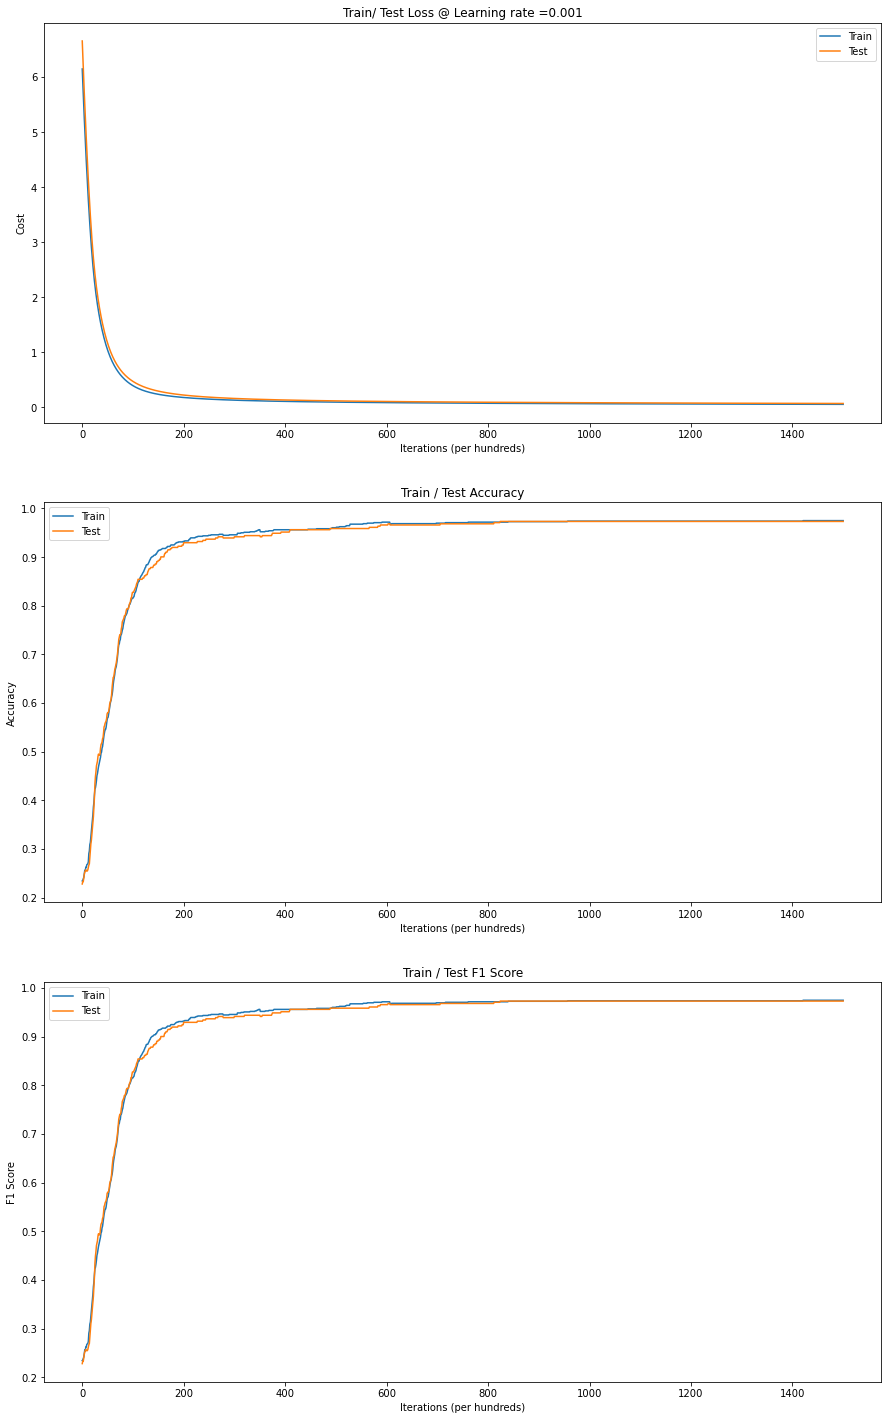

In [258]:
parameters = model(X_train, Y_train,X_test, Y_test, learning_rate= 0.001, num_iterations=1501, print_cost=True)